<h1><strong><u>Assignment 6 (SOM/MLP)</u></strong></h1>

In [17]:
%%capture
%run DataPreparation.ipynb

<h2><strong><u>Data Preprocessing</u></strong></h2>

<h3><u>Feature Engineering (SOM)</u></h3>

In [5]:
# separate numerical and non-numerical data
X_train_nonnumerical = X_train.drop(columns=numerical_columns)
X_test_nonnumerical = X_test.drop(columns=numerical_columns)
display(X_train_nonnumerical.describe())
display(X_test_nonnumerical.describe())

X_train_numerical = X_train[numerical_columns]
X_test_numerical = X_test[numerical_columns]
display(X_train_numerical.describe())
display(X_test_numerical.describe())

,island,sex
count,266,266
unique,3,2
top,Biscoe,MALE
freq,128,142


,island,sex
count,67,67
unique,3,2
top,Biscoe,FEMALE
freq,35,41


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,266.000000,266.000000,266.000000,266.000000
mean,44.497744,17.134962,201.808271,4253.289474
std,5.365930,2.020036,13.755167,793.770550
min,34.000000,13.100000,172.000000,2700.000000
25%,39.725000,15.300000,190.250000,3650.000000
50%,45.350000,17.450000,198.000000,4100.000000
75%,49.075000,18.700000,214.000000,4850.000000
max,59.600000,21.500000,230.000000,6300.000000


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,67.000000,67.000000,67.000000,67.000000
mean,41.988060,17.283582,197.626866,4023.507463
std,5.451731,1.762109,14.638923,829.976732
min,32.100000,13.700000,174.000000,2850.000000
25%,37.700000,16.250000,187.500000,3375.000000
50%,41.300000,17.200000,193.000000,3800.000000
75%,45.750000,18.500000,207.500000,4612.500000
max,54.300000,21.100000,231.000000,5950.000000


In [6]:
som = SOM(m=5, n=5, dim=X_train_numerical.shape[1], random_state=42)
som.fit(X_train_numerical.values)
som_train_predictions = som.predict(X_train_numerical.values)
som_test_predictions = som.predict(X_test_numerical.values)

In [9]:
X_train_nonnumerical_som = pd.DataFrame(np.append(X_train_nonnumerical, som_train_predictions.reshape(-1, 1), axis=1), columns=X_train_nonnumerical.columns.tolist() + ['SOM Category'])
X_test_nonnumerical_som = pd.DataFrame(np.append(X_test_nonnumerical, som_test_predictions.reshape(-1, 1), axis=1), columns=X_train_nonnumerical.columns.tolist() + ['SOM Category'])


display(X_train_nonnumerical_som.shape)
display(X_test_nonnumerical_som.shape)
display(X_train_nonnumerical_som.columns.tolist())
display(X_test_nonnumerical_som.columns.tolist())
display(X_train_nonnumerical_som.head(5))
display(X_test_nonnumerical_som.head(5))
preprocessor = make_column_transformer(
    (OneHotEncoder(), X_train_nonnumerical_som.columns.tolist()),
    remainder='passthrough'
)
X_train_processed = preprocessor.fit_transform(X_train_nonnumerical_som)
X_test_processed = preprocessor.transform(X_test_nonnumerical_som)
display(X_train_processed.shape)
display(X_test_processed.shape)


(266, 3)

(67, 3)

['island', 'sex', 'SOM Category']

['island', 'sex', 'SOM Category']

,island,sex,SOM Category
0,Biscoe,MALE,8
1,Dream,FEMALE,23
2,Biscoe,MALE,8
3,Biscoe,MALE,4
4,Dream,FEMALE,0


,island,sex,SOM Category
0,Biscoe,FEMALE,10
1,Biscoe,FEMALE,21
2,Biscoe,MALE,4
3,Biscoe,MALE,11
4,Biscoe,MALE,11


(266, 30)

(67, 30)

<h2><strong><u>MLP Model Selection</u></strong></h2>

<h3><strong><u>Validation Curves</u></strong></h3>

In [ ]:
# Validation Curve for Testing Effect of Neuron Count

pipeline = Pipeline(
    [
        ("clf", MLPClassifier(max_iter=2000))
    ]
)

hidden_layers = [(25,), (30,), (35,), (40,), (45,), (50,)]
neurons = list(range(25, 51, 5))
train_scores, validation_scores = validation_curve(pipeline, X_train_processed, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__hidden_layer_sizes",
                                                   param_range=hidden_layers,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

vc_dict[f"MLP Classifier: Accuracy VC (Neuron Count with One Layer) 2"] = [["Neuron Count", "Accuracy Score"],
                                                                          neurons,
                                                                          [train_scores_mean, validation_scores_mean],
                                                                          ["Train Scores", "Validation Scores"]]

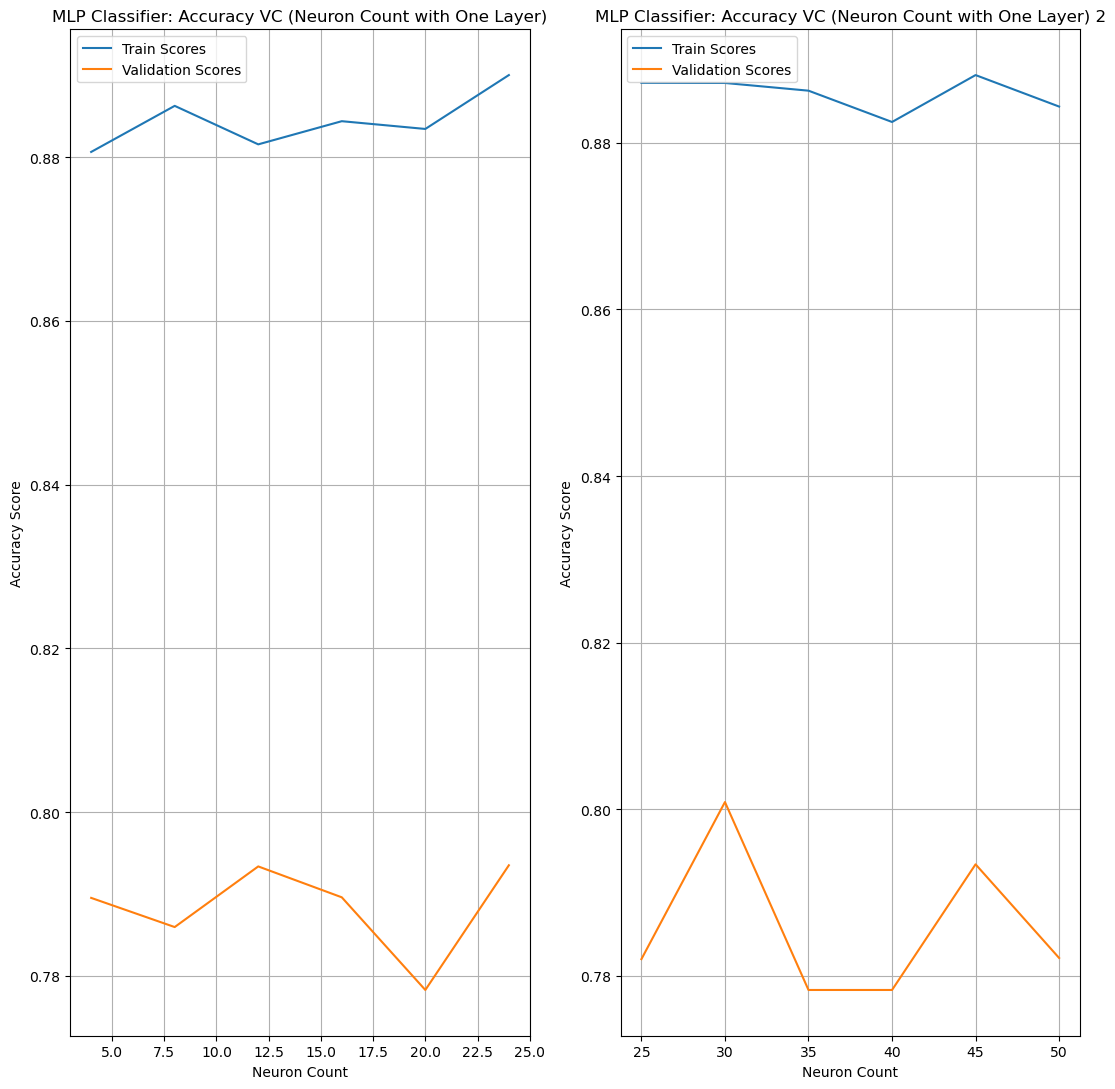

In [27]:
# Create an even number of subplots (e.g., 3 rows, 2 columns for 5 plots)
fig, axs = plt.subplots(1, 2, figsize=(11,11))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in vc_dict.items():
    axs[count].plot(value[1], value[2][0], label=value[3][0])
    axs[count].plot(value[1], value[2][1], label=value[3][1])
    axs[count].set_xlabel(value[0][0])
    axs[count].set_ylabel(value[0][1])
    axs[count].set_title(key)
    axs[count].grid()
    axs[count].minorticks_off()
    axs[count].legend()
    count += 1

# fig.delaxes(axs[count]) 
plt.tight_layout()
plt.show()

<h3><strong><u>Cross-Validation Test</u></strong></h3>

In [83]:
pipeline = Pipeline(
    [
        ("clf", MLPClassifier(max_iter=2000, random_state=42)),
    ]
)

cv_params = {
    'clf__hidden_layer_sizes': [(50, 2), (100, 2), (150, 2)],
}
grid_search = GridSearchCV(pipeline, cv_params, cv=5, n_jobs=-1, scoring='accuracy', verbose=3)
grid_search.fit(X_train_processed, y_train)
best_model = grid_search.best_estimator_
display(best_model)
y_train_pred = best_model.predict(X_train_processed)
y_test_pred = best_model.predict(X_test_processed)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Training Accuracy after Hyperparameter Tuning: {train_accuracy:.4f}")
print(f"Testing Accuracy after Hyperparameter Tuning: {test_accuracy:.4f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END ...clf__hidden_layer_sizes=(50, 2);, score=0.868 total time=   0.3s
[CV 2/5] END ..clf__hidden_layer_sizes=(100, 2);, score=0.887 total time=   0.3s
[CV 5/5] END ...clf__hidden_layer_sizes=(50, 2);, score=0.755 total time=   0.3s
[CV 1/5] END ..clf__hidden_layer_sizes=(100, 2);, score=0.778 total time=   0.4s
[CV 1/5] END ...clf__hidden_layer_sizes=(50, 2);, score=0.759 total time=   0.4s
[CV 4/5] END ...clf__hidden_layer_sizes=(50, 2);, score=0.811 total time=   0.4s
[CV 3/5] END ...clf__hidden_layer_sizes=(50, 2);, score=0.717 total time=   0.4s
[CV 3/5] END ..clf__hidden_layer_sizes=(100, 2);, score=0.717 total time=   0.3s
[CV 4/5] END ..clf__hidden_layer_sizes=(100, 2);, score=0.774 total time=   0.2s
[CV 4/5] END ..clf__hidden_layer_sizes=(150, 2);, score=0.660 total time=   0.2s
[CV 5/5] END ..clf__hidden_layer_sizes=(100, 2);, score=0.811 total time=   0.3s
[CV 2/5] END ..clf__hidden_layer_sizes=(150, 2);,

Pipeline(steps=[('clf',
                 MLPClassifier(hidden_layer_sizes=(100, 2), max_iter=2000,
                               random_state=42))])

Best Hyperparameters: {'clf__hidden_layer_sizes': (100, 2)}
Training Accuracy after Hyperparameter Tuning: 0.8759
Testing Accuracy after Hyperparameter Tuning: 0.8657


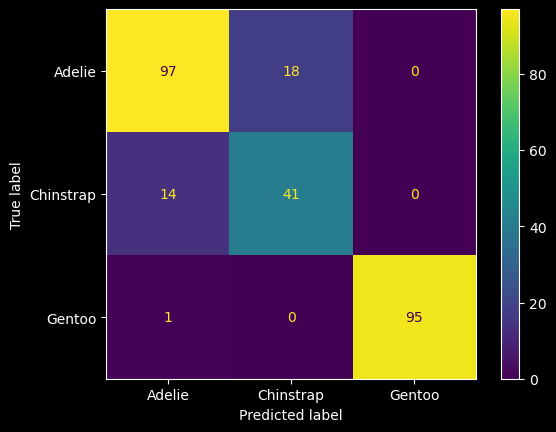

In [88]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

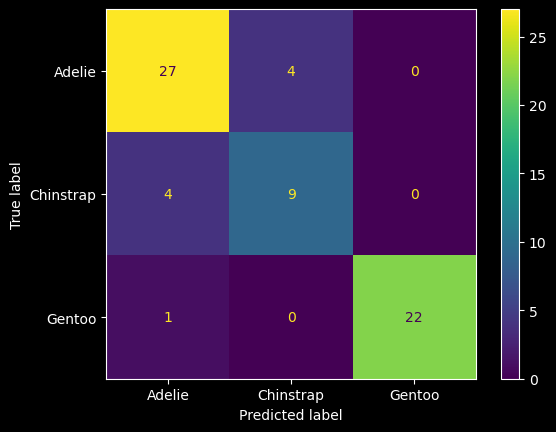

In [87]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)